In [95]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [97]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('/content/MSFT.csv')
df1=df.reset_index()['Close']

In [98]:
# 3. Scale data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [99]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [100]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [101]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [102]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [103]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [104]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 2s 44ms/step - loss: 0.0153 - val_loss: 0.0043
Epoch 2/100
14/14 [==============================] - 0s 27ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 3/100
14/14 [==============================] - 0s 30ms/step - loss: 5.6685e-04 - val_loss: 0.0012
Epoch 4/100
14/14 [==============================] - 0s 25ms/step - loss: 4.1982e-04 - val_loss: 0.0011
Epoch 5/100
14/14 [==============================] - 0s 25ms/step - loss: 3.3829e-04 - val_loss: 0.0011
Epoch 6/100
14/14 [==============================] - 0s 26ms/step - loss: 3.1631e-04 - val_loss: 0.0011
Epoch 7/100
14/14 [==============================] - 0s 25ms/step - loss: 2.9866e-04 - val_loss: 0.0011
Epoch 8/100
14/14 [==============================] - 0s 29ms/step - loss: 2.8999e-04 - val_loss: 0.0010
Epoch 9/100
14/14 [==============================] - 0s 26ms/step - loss: 2.8544e-04 - val_loss: 9.9286e-04
Epoch 10/100
14/14 [==============================] - 0s 25ms/step -

In [105]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 11ms/step


In [106]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [107]:
# 12. Tính RMSE, MAE, MAPE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mae = np.mean(np.abs(y_pred - ytest))
valid_mape = np.mean(np.abs((y_pred_val - yval) / yval))
test_mape = np.mean(np.abs((y_pred - ytest) / ytest))

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation RMSE: 310.74396755002925
Testing RMSE: 268.5379716333128
Validation MAE: 310.40628161877
Testing MAE: 267.67771403411587
Validation MAPE: 353.5679717500105
Testing MAPE: 388.5879240544752


In [109]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=80
i=0
while(i<30):

    if(len(temp_input)>80):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.9563624]
81
1 day input [0.65484871 0.65042172 0.66286308 0.64168229 0.64526968 0.64244555
 0.63042405 0.6488952  0.66484755 0.6708774  0.6604969  0.65877955
 0.65351302 0.63927796 0.65961916 0.68583757 0.7035836  0.74464765
 0.75697441 0.7294967  0.73541201 0.72972568 0.7502195  0.76132511
 0.74533456 0.74094578 0.76109614 0.77460596 0.79082548 0.78674206
 0.78655117 0.77571273 0.80341952 0.79498541 0.76995    0.77246881
 0.7967027  0.78258225 0.79273365 0.79109265 0.79139802 0.78246764
 0.78113201 0.76590467 0.74167089 0.81780715 0.85390986 0.86318369
 0.85669584 0.85612341 0.85226885 0.85612341 0.87612108 0.86848837
 0.8621914  0.88245625 0.87406021 0.86970963 0.8715796  0.8802809
 0.8889059  0.90615579 0.90546888 0.91630732 0.89371455 0.88833347
 0.93439693 0.96099694 0.95458537 0.94382334 0.95981377 0.97057592
 0.97263678 0.96401178 0.92470335 0.93187812 0.93771714 0.9570279
 0.96633982 0.95636243]
1 day output [[0.95687467]]
2 day input [0.65042172 0.66286308 0.64168229 0.6452

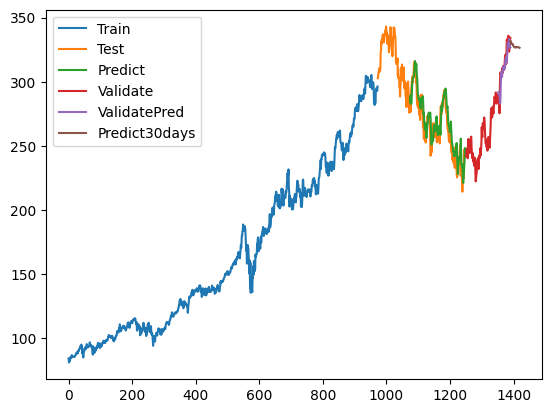

In [110]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')